Simple MIA aims at using a threshold to decide between train and test data.

In [16]:
import matplotlib.pyplot as plt
import polars as pl

from privacy_and_grokking.path_keeper import get_path_keeper

In [3]:
pk = get_path_keeper()

In [53]:
pk.set_params({"run_id": "v1.2.4", "model": "MLP_GROK_V1", "step": "100000"})

def postprocess(df: pl.DataFrame) -> pl.DataFrame:
    labels = df["correct_label"].unique().sort().to_list() 
    expressions = [
        pl.when(pl.col("correct_label") == label).then(pl.col(f"logit_{label}"))
        for label in labels
    ]
    return df.with_columns(
        pl.coalesce(*expressions).alias("correct_logit")
    )

df_train = pl.read_parquet(pk.TRAIN_LOGITS)
df_test = pl.read_parquet(pk.TEST_LOGITS)
df_train = postprocess(df_train)
df_test = postprocess(df_test)

In [54]:
df_train.head()

index,correct_label,logit_0,logit_1,logit_2,logit_3,logit_4,logit_5,logit_6,logit_7,logit_8,logit_9,step,correct_logit
i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,f32
0,5,0.000217,0.000295,0.000461,0.000456,0.000377,0.998293,0.000393,0.000495,0.000394,0.000556,100000,0.998293
1,9,-0.000392,-0.000238,-0.000355,-0.000192,-0.000073,0.00002,-0.000508,-0.000127,-0.000346,1.001302,100000,1.001302
2,8,-0.000243,0.000089,-0.000039,-0.000239,-0.00001,-0.000005,-0.000149,-0.000275,0.998713,0.000079,100000,0.998713
3,1,-0.000107,0.999392,-0.000155,-0.000152,0.000071,-0.000133,-0.000127,-0.000326,-0.000337,0.000292,100000,0.999392
4,6,-0.000017,0.000086,-0.000086,0.000014,0.000229,0.000547,0.998183,0.000198,-0.000277,0.000337,100000,0.998183


In [55]:
df_train.head()

index,correct_label,logit_0,logit_1,logit_2,logit_3,logit_4,logit_5,logit_6,logit_7,logit_8,logit_9,step,correct_logit
i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,f32
0,5,0.000217,0.000295,0.000461,0.000456,0.000377,0.998293,0.000393,0.000495,0.000394,0.000556,100000,0.998293
1,9,-0.000392,-0.000238,-0.000355,-0.000192,-0.000073,0.00002,-0.000508,-0.000127,-0.000346,1.001302,100000,1.001302
2,8,-0.000243,0.000089,-0.000039,-0.000239,-0.00001,-0.000005,-0.000149,-0.000275,0.998713,0.000079,100000,0.998713
3,1,-0.000107,0.999392,-0.000155,-0.000152,0.000071,-0.000133,-0.000127,-0.000326,-0.000337,0.000292,100000,0.999392
4,6,-0.000017,0.000086,-0.000086,0.000014,0.000229,0.000547,0.998183,0.000198,-0.000277,0.000337,100000,0.998183


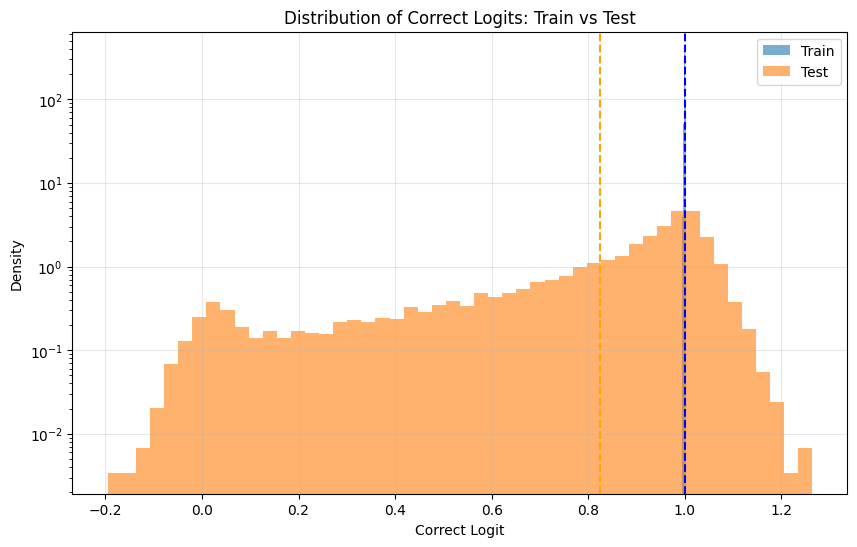

In [56]:
plt.figure(figsize=(10, 6))
plt.hist(df_train["correct_logit"].to_numpy(), bins=50, alpha=0.6, label="Train", density=True)
plt.hist(df_test["correct_logit"].to_numpy(), bins=50, alpha=0.6, label="Test", density=True)
plt.xlabel("Correct Logit")
plt.ylabel("Density")
plt.yscale("log")
plt.title("Distribution of Correct Logits: Train vs Test")
plt.legend()
plt.axvline(x=df_train["correct_logit"].mean(), color="blue", linestyle="--", label="Train Mean")
plt.axvline(x=df_test["correct_logit"].mean(), color="orange", linestyle="--", label="Test Mean")
plt.grid(True, alpha=0.3)
# plt.xlim(0.995, 1.0025)
plt.show()

In [ ]:
# The values 0.995 and 1.0025 were chosen based on the histogram visualization above (zooming in a bit).
df_train_inferred = df_train.with_columns(
    pl.when((pl.col("correct_logit") > 0.995) & (pl.col("correct_logit") < 1.0025)).then(1).otherwise(0).alias("inferred_member")
)
df_test_inferred = df_test.with_columns(
    pl.when((pl.col("correct_logit") > 0.995) & (pl.col("correct_logit") < 1.0025)).then(0).otherwise(1).alias("inferred_member")
)

In [58]:
df_train_inferred["inferred_member"].sum() / df_train_inferred.height, df_test_inferred["inferred_member"].sum() / df_test_inferred.height

(0.991, 0.9614)

In [52]:
df_train_inferred.height, df_test_inferred.height

(60000, 10000)